# Model Pipeline

`roboflow` : 객체 탐지 -> `predict2crop()` : 이미지 크롭 -> `CLOVA_api()`: OCR_api -> 텍스트 추출

- packages

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
import requests
import base64
import uuid
import json
import time
import cv2
import requests
import platform
from google.colab.patches import cv2_imshow
import numpy as np
import os

In [5]:
image_folder = '/content/drive/MyDrive/Datas/train/' # 데이터가 존재하는 폴더 경로
files = os.listdir(image_folder)
image_files = [file for file in files] # 데이터 접근 : 다중 파일로 테스트 시, 파일 순회

# input data Example
input_img = '2643504753BD349D1D.jpeg'

## Modules

In [17]:
def CLOVA_api(secret_key, api_url, image : np.array):
    """
    Usage : CLOVA api 호출

    Parameters
    ----------
    secret_key : api key
    api_url : api_url
    image : 크롭된 image

    Returns
    -------

    response : api 호출 결과 (ex. 200,400,404, ...)

    """
    # Convert np.ndarray to bytes
    if image is not None:
        _, buffer = cv2.imencode('.jpg', image)
        file_data = buffer.tobytes()

    request_json = {
        'images': [
            {
                'format': 'jpg',
                'name': 'demo',
                'data': base64.b64encode(file_data).decode()
                #'url': image_url
            }
        ],
        'requestId': str(uuid.uuid4()),
        'version': 'V2',
        'timestamp': int(round(time.time() * 1000))
    }
    payload = json.dumps(request_json).encode('UTF-8')
    headers = {
      'X-OCR-SECRET': secret_key,
      'Content-Type': 'application/json'
    }
    response = requests.request("POST", api_url, headers=headers, data = payload)

    return response


def imageOCR(response, img : np.array):
    """
    Usage : api 적용 결과 (OCR 결과) 시각화

    Parameters
    ----------
    response : api 호출 결과
    img : 크롭된 이미지

    Returns
    -------
    temp : 추출된 text
    image : 크롭된 이미지 내 OCR 적용 결과

    """
    try : result = response.json()
    except :
        print(response, 'AttributeError: Responsed \'int\' object' )

    with open('result.json', 'w', encoding='utf-8') as make_file:
        json.dump(result, make_file, indent="\t", ensure_ascii=False)

    # Error 처리
    try : print(result['images'][0]['message'])
    except : return None, None

    # respone.json()에서 띄어쓰기 처리
    texts = connectWord(result)

    # 이미지 시각화
    bBs = [b['boundingPoly'] for b in result['images'][0]['fields']]

    # bounding box 표시
    for box in bBs:
        vertices = np.array([(int(point['x']), int(point['y'])) for point in box['vertices']], np.int32)
        vertices = vertices.reshape((-1, 1, 2))
        img = cv2.polylines(img, [vertices], isClosed=True, color=(255, 0, 0), thickness=2)

    # 이미지 보여주기
    cv2_imshow(img) # only colab
    # print(text)

    return texts, img

def connectWord(ocr_json):
    detected_texts = ''

    # 필드 정보 추출
    fields = ocr_json['images'][0].get('fields', [])

    # 각 필드에 대해 y좌표 계산
    word_list = []
    for field in fields:
        bounding_poly = field.get('boundingPoly')
        infer_text = field.get('inferText')

        if bounding_poly and infer_text:
            vertices = bounding_poly['vertices']
            y_coord = vertices[0]['y']  # 첫 번째 꼭짓점의 y좌표를 사용
            word = infer_text
            word_list.append({'word': word, 'y_coord': y_coord})

    # y좌표가 유사한 단어를 그룹화
    grouped_words = []
    if word_list:  # word_list가 비어있지 않은 경우에만 처리
        current_group = [word_list[0]]

        for i in range(1, len(word_list)):
            if abs(word_list[i]['y_coord'] - word_list[i-1]['y_coord']) < 10:
                current_group.append(word_list[i])
            else:
                grouped_words.append(current_group)
                current_group = [word_list[i]]

        if current_group:
            grouped_words.append(current_group)

    # 결과 출력
    # print(f'File: {file_name}')
    for group in grouped_words:
        # 그룹 내의 단어들을 하나의 문자열로 합침
        group_text = ' '.join([word_info['word'] for word_info in group])

        # 문자열이 정수로만 이루어져 있지 않은 경우에만 출력
        if not group_text.isdigit():
            detected_texts += group_text
            print(group_text)
    detected_texts += '\n'
    print('\n')

    return detected_texts

def modelPredict(model, input_Data):
    try : predictions_data = model.predict(input_Data, confidence=50, overlap=50).json()
    except :
        print('Predict Error')
        return None
    # image_path = predictions_data['predictions'][0]['image_path']  # Assuming all predictions have the same image path

    return predictions_data

def predict2crop(model, folder_path, image_file, resize = 256):
    """
    Usage : 객체 탐지 및 원본 및 크롭 이미지 return

    Parameters
    ----------
    model : Object Detection Model
    folder_path : 데이터 폴더 경로
    image_file : 데이터 파일 경로

    Returns : (original_image, cropped_image)
    -------
    type : tuple
    original_image : 원본 이미지
    cropped_image : 크롭된 이미지

    """
    print("="*50)
    print(image_file)
    image_path = folder_path + image_file
    img_size = resize # img_size * img_size

    org_img = cv2.imread(image_path)
    if org_img is None:
        print(f"Error: Unable to read the image file {image_path}")
        return None, None

    rsz_img = cv2.resize(org_img, (img_size, img_size), interpolation= cv2.INTER_AREA)
    adc_img = auto_adjust_contrast(rsz_img)


    predictions_data = modelPredict(model, input_Data = adc_img) # resize된 img속에서 찾은 bbox 좌표

    print('Detected : ', len(predictions_data['predictions']))

    if predictions_data is None :
        print('Detect Nothing. It\'s Too Close')
        return org_img, org_img

    if len(predictions_data['predictions']) > 1:
        print('! Error : Multiple detection Error. Take more closer')
        return None, None

    orgBBcoor = predBBcoor(org_img, predictions_data)
    cropped_img = imgCrop(org_img, orgBBcoor) #원본이미지에서 crop

    return org_img, cropped_img

def imgCrop(img, bbCoor):
    if None in bbCoor : return img

    x, y, width, height = bbCoor # real coordinate

    half_w, half_h = round(width/2), round(height/2)
    cropped_img = img[y-half_h : y+half_h, x-half_w : x+half_w] # img crop

    # # 결과 시각화
    cv2.rectangle(img, (x - half_w, y - half_h), (x + half_w, y + half_h), (0, 255, 0), 2)
    print('\n Original')
    cv2_imshow(img) # only colab
    # print('\n Cropped')
    # cv2_imshow(cropped_img) # only colab

    return cropped_img

def predBBcoor(org_img : np.array, pred_data : list, resize=256):
    """
    Usage : resize된 이미지에서의 바운딩 박스 좌표를 원본 이미지의 바운딩 박스 좌표로 변환

    Parameters
    ----------
    org_img : 원본 이미지(no resize)
    pred_data : list

    Returns : tuple
    -------
    x, y, width, height

    """
    try : prediction = pred_data['predictions'][0] # dict
    except : return None, None, None, None # 탐지 되지 않을 시

    # resized bbox coordinate
    rx, ry, rwidth, rheight = int(prediction['x']), int(prediction['y']), int(prediction['width']), int(prediction['height'])
    half_w, half_h = round(rwidth/2), round(rheight/2)

    # real h, w
    h, w, _ = org_img.shape
    # real bbox coordinate
    x, y, width, height = round((w*rx)/resize), round((h*ry)/resize), round((rwidth*w)/256), round((rheight*h)/256)

    return x, y, width, height

# preprocessing : auto_adjust_contrast
def auto_adjust_contrast(image : np.array):
    # Flatten the image to 1D array
    try : flat_image = image.flatten()
    except : return None

    # Compute the histogram
    histogram, bins = np.histogram(flat_image, bins=256, range=(0, 256))

    # Compute the cumulative distribution function (CDF)
    cdf = histogram.cumsum()

    # Normalize the CDF
    cdf_normalized = cdf / cdf.max()

    # Perform histogram equalization
    equalized_image = np.interp(flat_image, bins[:-1], cdf_normalized * 255).reshape(image.shape)

    return equalized_image.astype(np.uint8) # np.array

- model load

In [7]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="eyKD4VJQ4nRqtosRytMg")
project = rf.workspace().project("price-tag-dxlmv")
model = project.version(15).model

model

loading Roboflow workspace...
loading Roboflow project...


.ipynb_checkpoints
Error: Unable to read the image file /content/drive/MyDrive/Datas/train/.ipynb_checkpoints
common-43.jpeg
Detected :  1

 Original


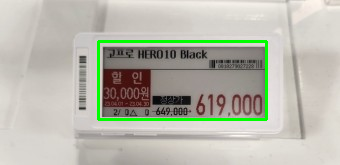

SUCCESS
고프로 HERO10 Black
할인
30,000원
저자가 619,000
2/0△ 0-669-000




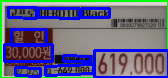

common-4.jpeg
Detected :  1

 Original


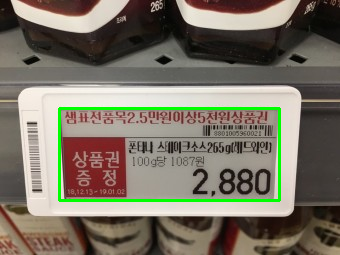

SUCCESS
샘표선품도2.5만원이상5천원상품권
10010800021 폰테나 스테0크소스265g(2)드와인]
상품권 100g당 1087원
증정 2,880
18.12.13-1901 01




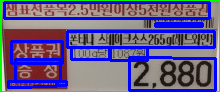

common-7.jpeg
Detected :  1

 Original


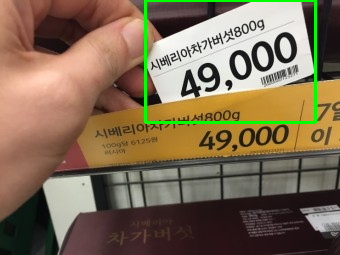

SUCCESS
시베리아차가버섯800g
49,000
8서800g




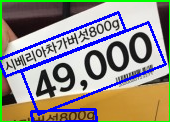

common-8.jpeg
Detected :  2
! Error : Multiple detection Error. Take more closer
common-11.jpeg
Detected :  1

 Original


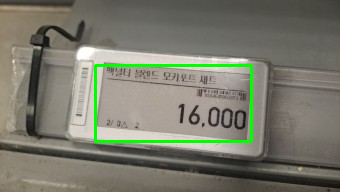

SUCCESS
팩널티 블렌드 모카포트 세트
16,000
2/3△ 2




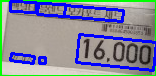

common-13.jpeg
Detected :  1

 Original


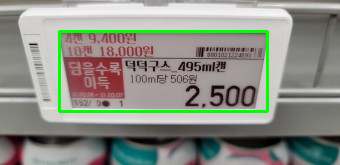

SUCCESS
9,400원
10개 18,000원
담을수록 덕덕구스_495ml캔
이득 100ml당506원
2,500




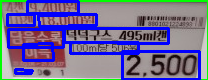

common-12.jpeg
Detected :  0
SUCCESS
APPLE애플
아이팟터치MP3
32GB/ BLACK
APPLE IPCO TOUCH 32GB PLA 음악재생시험대38시간 ONLISR#10 동영상재생시험대B사가 DOCK험문IES QUYE struhamnum Bracch ### 110V KIEY Aiya 1150 443,900원




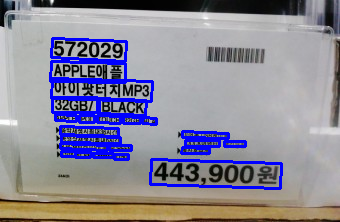

common-18.jpeg
Detected :  1

 Original


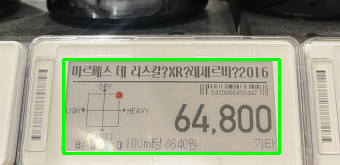

SUCCESS
마르께스 테리스칼?XR?레세르비2016
HEAVA 64 800
R」 0 100ml당 8640원 기타




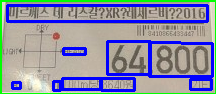

common-15.jpeg
Detected :  3
! Error : Multiple detection Error. Take more closer
common-21.jpeg
Detected :  1

 Original


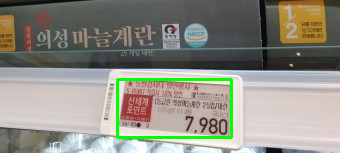

SUCCESS
신세계 25851117
7,980




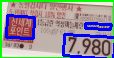

common-17.jpeg
Detected :  1

 Original


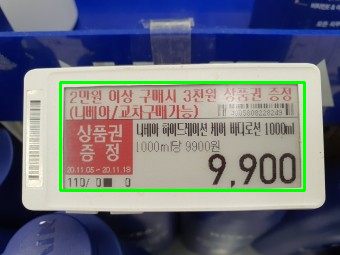

SUCCESS
2만원 이상 구매시 3전원 상품권 증정
(니베아/교차구매가능) 日
상품권 니베아 하이드레이션 케어 바디로션 1000ml
1000ml당9900원 증정
0.11:05-2011.18
9,900
110/ 0




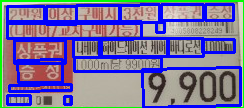

common-20.jpeg
Detected :  1

 Original


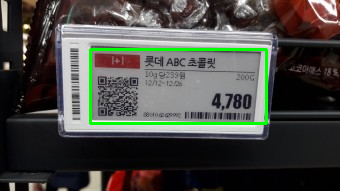

SUCCESS
+ 롯데ABC초콜릿
10g52399 2000 12/12~12/24
4,780




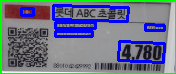

common-25.jpeg
Detected :  2
! Error : Multiple detection Error. Take more closer
common-19.jpeg
Detected :  1

 Original


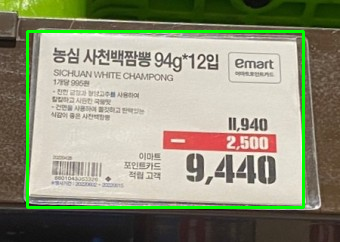

SUCCESS
농심 사천백짬뽕 94g*12입 emart
SICHIJAN WHITE CHAMPONG CCV: Ri-ri
11,940
2,500
이마트 9,440 포인트카드
적립고객




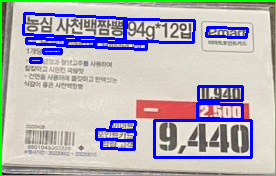

common-27.jpeg
Detected :  1

 Original


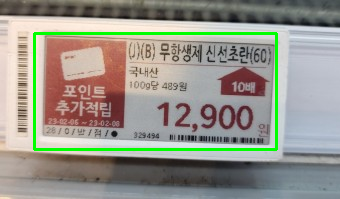

SUCCESS
(J)(B)무항생제신선초란(60)
국내산
100g당 489원 10배 포인트
추가적립 12,900
23-02-05 ### 원 2010/박/점/ 250




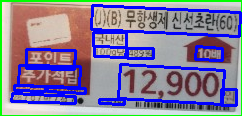

common-26.jpeg
Detected :  1

 Original


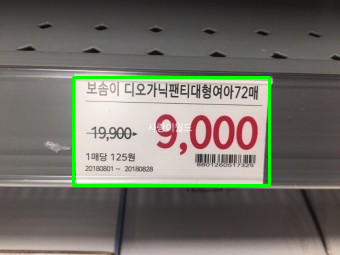

SUCCESS
보솜이 디오가닉팬티대형여아72매
19,900
,000
1매당 125
20180801 20180808




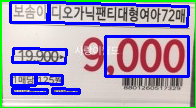

common-28.jpeg
Detected :  1

 Original


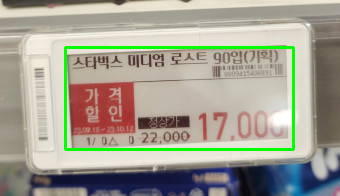

SUCCESS
스타벅스 미디엄 로스트 90입(기획)
가결
정상가 17,000
1/0△ 0 22.000




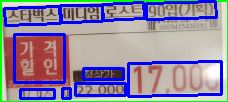

common-24.jpeg
Detected :  1

 Original


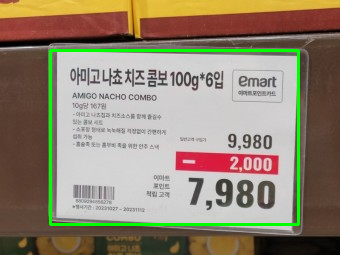

SUCCESS
아미고나쵸치즈콤보100g*6입
emart
AMIGO NACHO COMBO 1086 1679
AND PORT 9,980
2,000
GREE 7,980 美中美 자리 경제




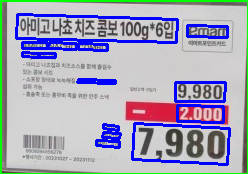

common-30.jpeg
Detected :  1

 Original


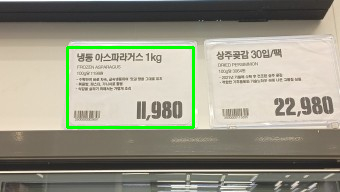

SUCCESS
냉동아스파라거스1kg
11,980




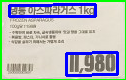

common-29.jpeg
Detected :  1

 Original


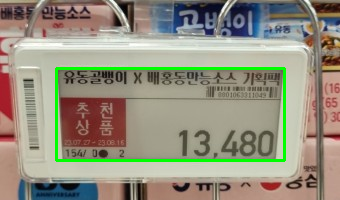

SUCCESS
유동골뱅이 x 배홍동만능소스 기획팩
추천
상품
PUB7272230810
13,480
154/ 日 2




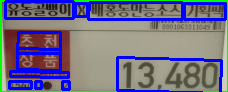

common-31.jpeg
Detected :  1

 Original


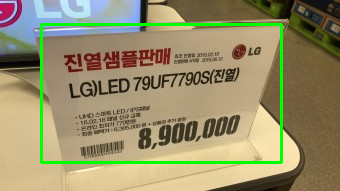

SUCCESS
진열샘플판매 TUROUU LG
LG)LED 79UF7790S(진열)
(NO)스미드 LED/IS
18:00 16:00 200
은메인 ### 8,900,000




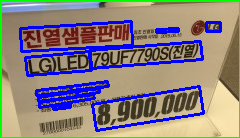

common-33.jpeg
Detected :  1

 Original


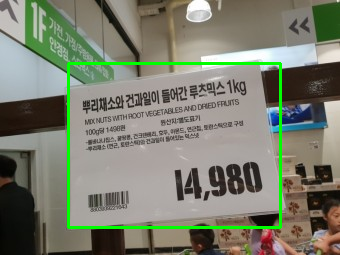

SUCCESS
뿌리채소와 건과일이
들어간 루츠믹스 1kg
MYCMUTSIMTHROOTVIEGETABLESANDDAEDERLITS
400de +1088 동산1번:
MARKINA ### A·UTAA 中 年月日 OU.SKT 트라스트오프 구성
600 NULLE
### 201412010
14,980




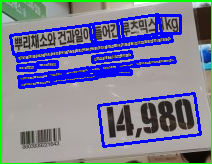

common-32.jpeg
Detected :  1

 Original


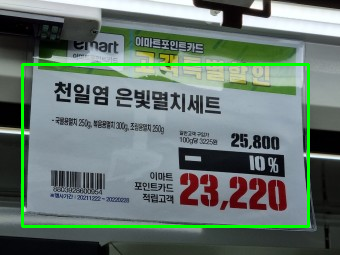

SUCCESS
말인
천일염 은빛멸치세트
20081250 NCV310300 자유담화 550ml ### 25,800 100ccc
10%
이마트 23,220
포인트카드 YOU.YU 적립고객




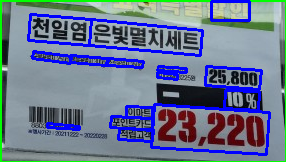

common-42.jpeg
Detected :  1

 Original


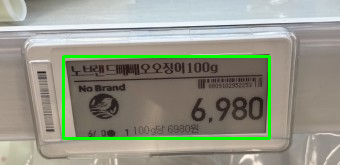

SUCCESS
노브랜드III빼오오징어100g
No Brand
6,980
57.06 1100ord 6980원




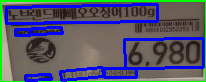

common-36.jpeg
Detected :  2
! Error : Multiple detection Error. Take more closer
common-37.jpeg
Detected :  0
SUCCESS
4캔 구매 시 9,960원
동일행사품목 교차가능 4002103292876
담을수록 메딩거 헤페_500ml_캔
100ml당 600원 이득
23.12.01=23.12.14
3,000
25/ 0 2




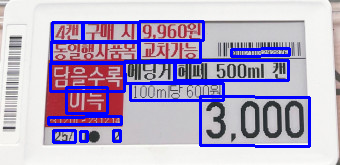

common-38.jpeg
Detected :  1

 Original


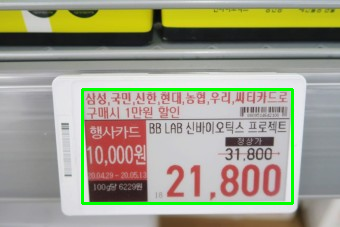

SUCCESS
삼성,국민,신한,현대,농,우리,씨티카드로
구매시 1만원 할인
행사카드 BB LAB신바이오틱스 프로젝트
정상가 10,000원 31,800
100d50 6229원
21,800




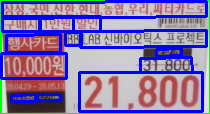

common-41.jpeg
Detected :  1

 Original


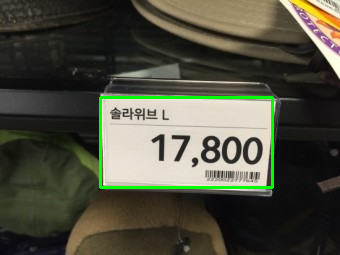

SUCCESS
솔라위브 L
17, ,800




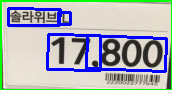

common-39.jpeg
Detected :  1

 Original


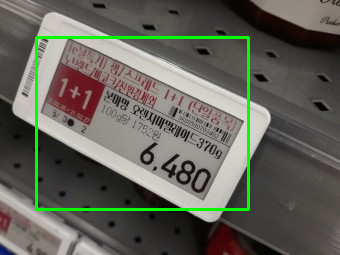

SUCCESS
1+1
돈이에
신원영세이
100 오리 5 25.00.22 25
2 1752원
370g 6,480




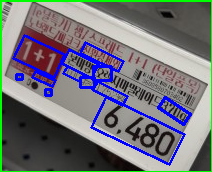

common-44.jpeg
Detected :  1

 Original


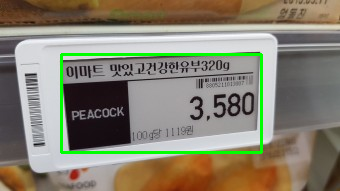

SUCCESS
이마트 맛있고건강한유부320g
PEACOCK
3,580
100g당11.19원




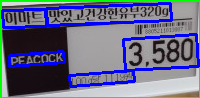

common-46.jpeg
Detected :  1

 Original


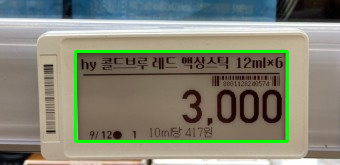

SUCCESS
hy 콜드브루 레드 액상스틱 12mlx6
3,000
9/12 1 10ml당 417원




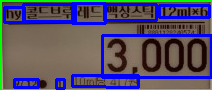

common-50.jpeg
Detected :  1

 Original


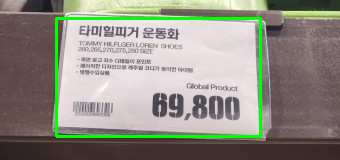

SUCCESS
타미힐피거 운동화
TOMMY HELEGERLODEN GREE ###
### ### Dueme 900 ###
Green Drivksm 69,800




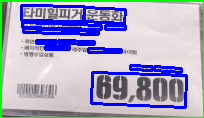

common-40.jpeg
Detected :  1

 Original


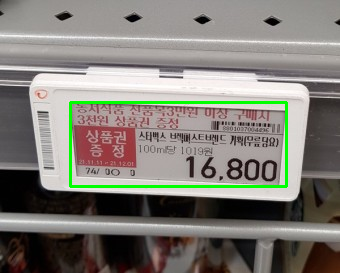

SUCCESS
동시작품 전품목3만원원 구매시 3천원 상품권 증정
상품권 스타벅스 브렉퍼스트브랜드기억(무릎담요)
증정 100ml당 1019원
16,800
741 OO D




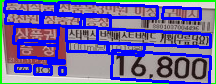

common-49.jpeg
Detected :  1

 Original


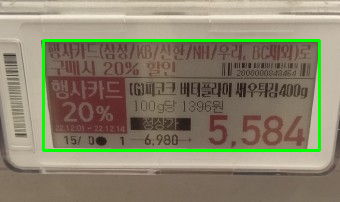

SUCCESS
사카드(삼성/KB/신한/NIH/우리, BC제외)로
구매시 20% 할인
행사카드 [G]피코크 버터플라이새우튀김400g
100g당 1396원 20%
정상가 5,584
2723710 15/ 10 1 6,980




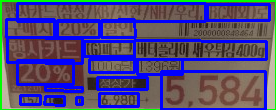

common-51.jpeg
Detected :  1

 Original


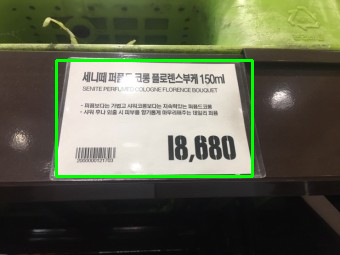

SUCCESS
세니페 퍼플 크롱플플랜스부케150ml
###
(1) TAXI LINE 0 012
18,680




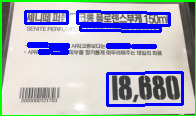

common-52.jpeg
Detected :  1

 Original


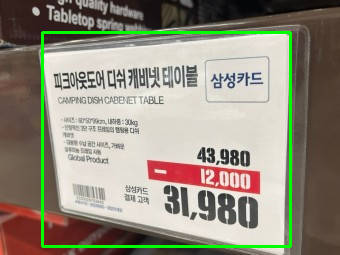

SUCCESS
피크아웃도어 | 디쉬 캐비넷 테이블 삼성카드
CAMPINGDISHCAEENETTABLE
1:00:00 ### CIN
1 43,980
GreatProduct
12,000
삼성카드 결제 고객
31,980




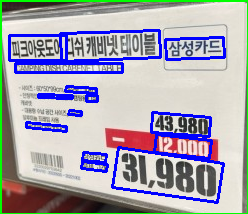

common-55.jpeg
Detected :  2
! Error : Multiple detection Error. Take more closer
common-54.jpeg
Detected :  1

 Original


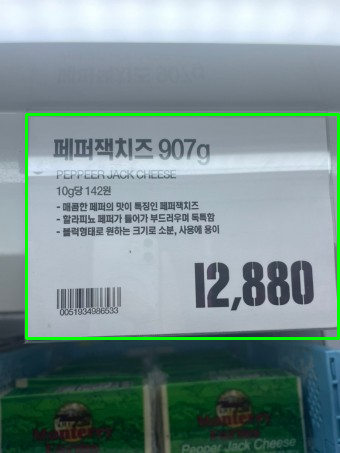

SUCCESS
페퍼잭치즈907g
PERPEER JACCHCESE
10g당142원
- 매콤한 페퍼의 맛이 특징인 페퍼잭치즈
- 할라피뇨 페퍼가 들어가 부드러우며독특함
- 블럭형태로 원하는 크기로 소분, 사용에 용이
00519349816-333
12,880




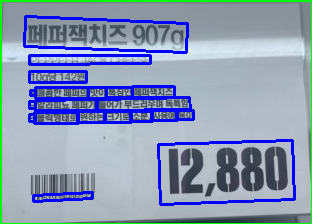

common-57.jpeg
Detected :  1

 Original


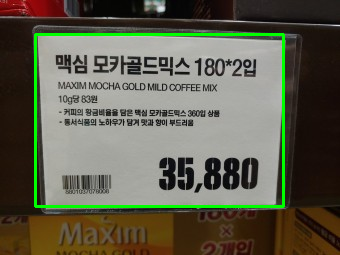

SUCCESS
맥심 모카골드믹스180*2입
MAXIM MOCHAGOLD MILDCOFFEE MIX
10g당 83은
. 커피의 황금비율을 담은 핵심 모카골드맥스380입 상품
- 동서식품의 노하우기담겨 맛과 향미 부리얼
35,880




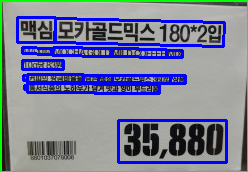

common-60.jpeg
Detected :  0
SUCCESS
OPEN
축하기념
양평점 단독 특가행사 2채널 블랙박스 위니캠엣지
FHD+DI
99,000
(SODE)-05/18 ### 24 ###




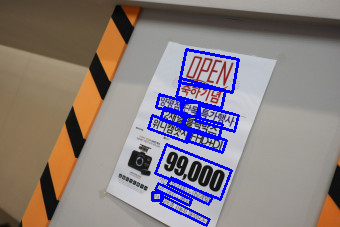

common-61.jpeg
Detected :  1

 Original


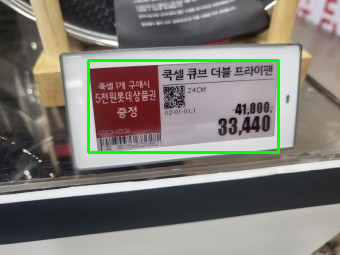

SUCCESS
쿡셀 큐브 더블 프라이팬
룩셈1개 구매시
5천원롯데상품권 24CM
증정 MALAL 41.800
33,440




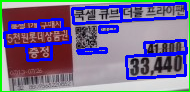

common-62.jpeg
Detected :  1

 Original


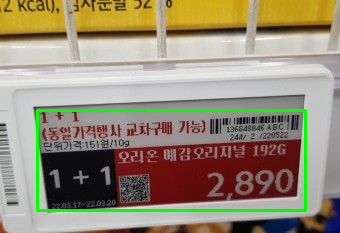

SUCCESS
1 + 1
(동일가격행사 교차구매 가능) 12C040040 ▲BC 2 2220522 단위가격:15원/10g 오리온 예감오리지널 1926
1 + 1 2,890




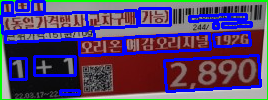

common-63.jpeg
Detected :  2
! Error : Multiple detection Error. Take more closer
common-69.jpeg
Detected :  1

 Original


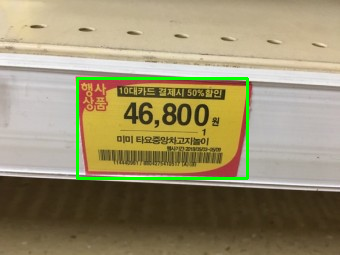

SUCCESS
행사 10대카드 결제시 50%할인 상품 46,800
원
1 미미 타요중앙차고지놀이




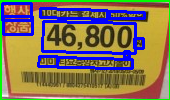

common-64.jpeg
Detected :  2
! Error : Multiple detection Error. Take more closer
common-67.jpeg
Detected :  3
! Error : Multiple detection Error. Take more closer
common-70.jpeg
Detected :  1

 Original


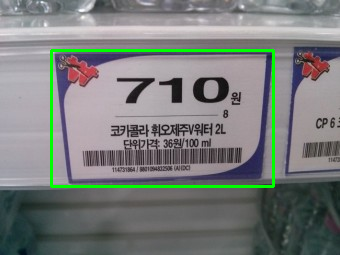

SUCCESS
원
코카콜라 휘오제주V워터 2L
단위가격:36/원이
Midea 00




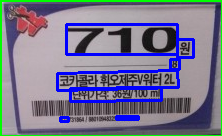

common-73.jpeg
Detected :  1

 Original


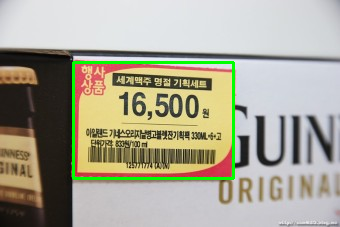

SUCCESS
행사
상품 세계맥주 명절기획세트
16,500
원
아일랜드 기네스오리지범고불렛전기획팩 330ML47 EIRORO 1300/100ml




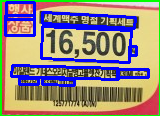

common-71.jpeg
Detected :  1

 Original


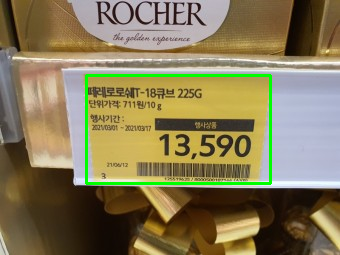

SUCCESS
떼레로로쉐T18큐브225G
단위가격:711원/10g
행사기간:
2021.03.05~30.20(031) 13,590
HW




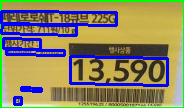

common-78.jpeg
Detected :  1

 Original


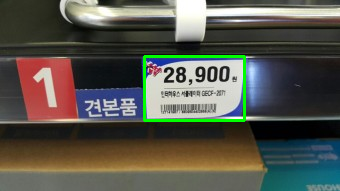

SUCCESS
28,900.
ICHOA 0:20~1:30




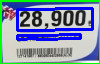

common-76.jpeg
Detected :  0
SUCCESS
20% 하이
레고 제이의타이탄로봇 71785 20%
정상가 114 900
할인
420-23.05.10
91,900




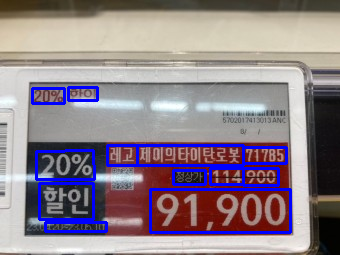

common-75.jpeg
Detected :  1

 Original


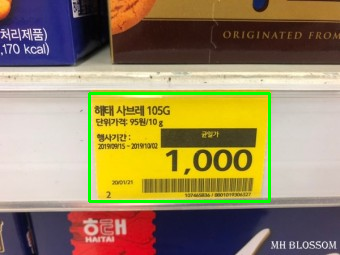

SUCCESS
해태 사브레 105G
단위가격 95위/10g
균일가 행사기간:
2010/01/12:30restations 1,000




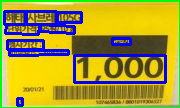

common-5.jpeg
Detected :  1

 Original


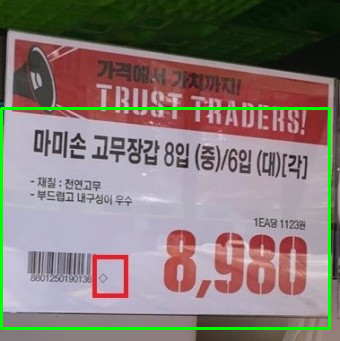

SUCCESS
HAVERS!
마미손 고무장갑8입(중)/6입(대)[각]
- 재질 : 천연고무
- 부드럽고 내구성이 우수
1FAR 11238
8,980




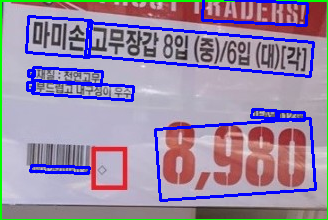

common-80.jpeg
Detected :  1

 Original


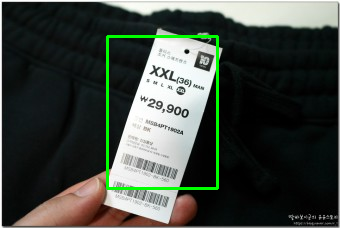

SUCCESS
XXL(36)
MLX
w29,
,900




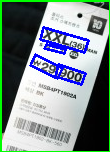

common-6.jpeg
Detected :  1

 Original


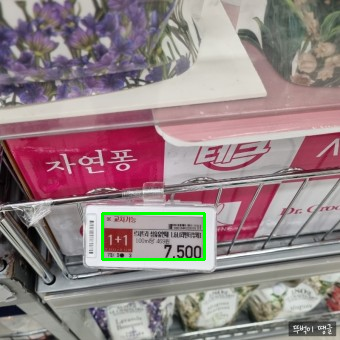

SUCCESS
고시가능
1+1 7.500




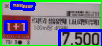

common-85.jpeg
Detected :  1

 Original


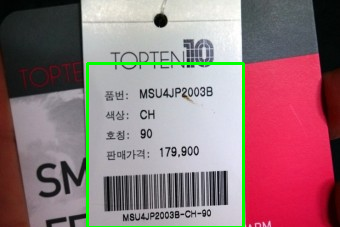

SUCCESS
품번: MSU4JP2003B
색상: CH
호칭: 90
판매가격: 179,900
MSU4JP20038-CH-90




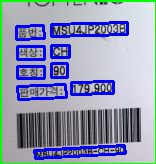

common-2.jpeg
Detected :  1

 Original


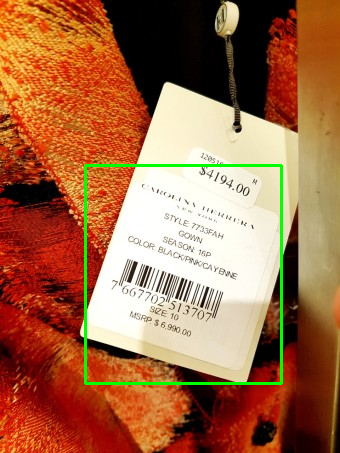

SUCCESS
$4194.00
STYLE
7723FAH GOWN SEASON
16D
COLOR
BLACK/PNKKAYBNNF
SIZE 10 MSPP S690000




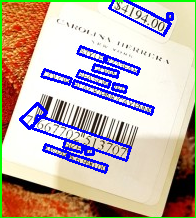

common-22.jpeg
Detected :  1

 Original


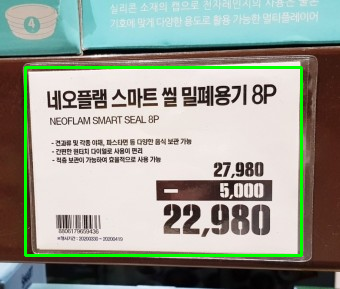

SUCCESS
네오플램 스마트 씰 밀폐용기 8P
NEOFLAM SMART SEAL 8P
2136 및 이미 BADP E 다양한 음식 부관 가능 COOL 사용이 편리 최종 보쌈이 7th#### OMMOO Visi 기는 27,980
5,000
22,980




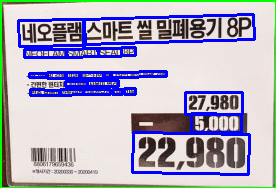

common-23.jpeg
Detected :  1

 Original


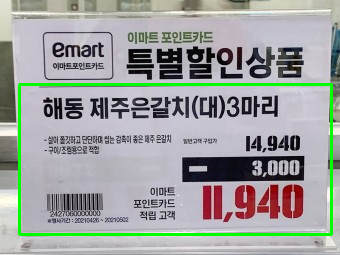

SUCCESS
해동 제주은갈치(대)3마리
감축이 좋은 제주 은갈치 살이 쫄깃하고 단단하며 접는 ### 287 14,940
JINIXERO 적합
3,000
이마트 11,940
포인트카드
000 적립 고객 ·YAMAHA 90095600




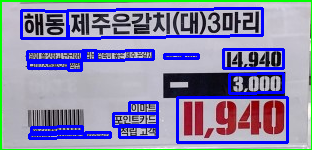

common-9.jpeg
Detected :  4
! Error : Multiple detection Error. Take more closer
common-86.jpeg
Detected :  4
! Error : Multiple detection Error. Take more closer
common-45.jpeg
Detected :  0
SUCCESS
자취요리신 simple cooking 잠을
1일 전
X마트 가격표 나만 몰랐음??
이거 종이인 줄 알았는데
액정 화면임....
JJIU 1700
2,480 2,480




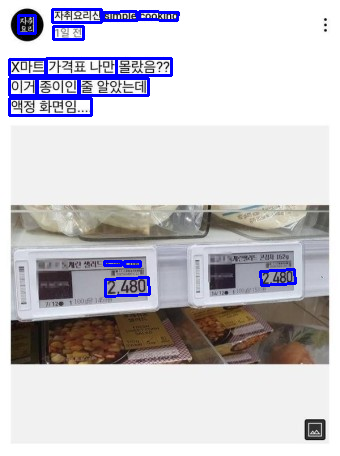

common-34.jpeg
Detected :  1

 Original


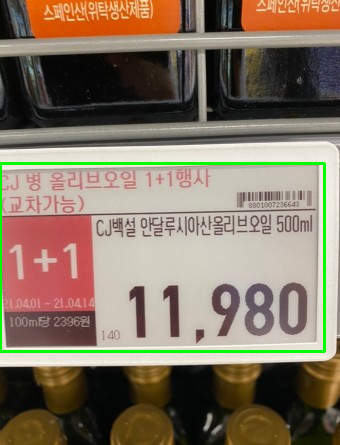

SUCCESS
CJ 병 올리브오일 1+1행사
(교차가능) 8801007235543
CJ백설 안달루시아산올리브오일 500ml
1+1
10401-210414
11,980
100ml당2396원




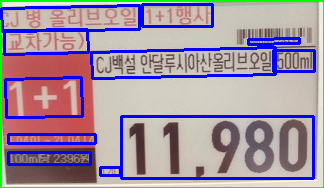

common-35.jpeg
Detected :  1

 Original


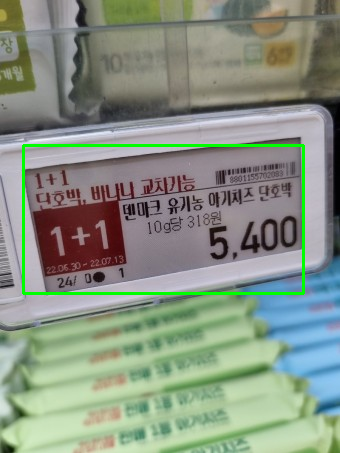

SUCCESS
1+1
단호박, 바나나 교차가능
덴마크 유기농 아기치즈
단호박
1+1 10g당318원
22.06.30-2207.13
5,400
24/ 0 1




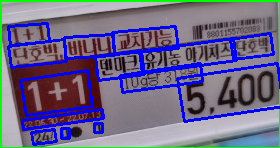

common-47.jpeg
Detected :  1

 Original


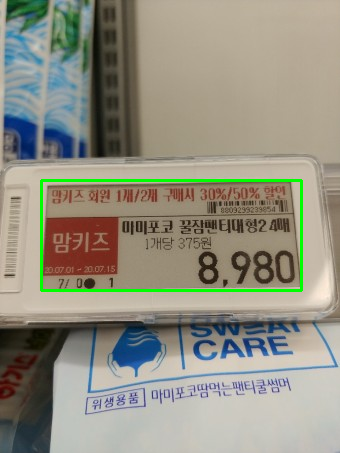

SUCCESS
맘키즈 회원 1개/2개 구매시 30%/50% 할인
마미포코 꿀잠팬티대형24매
맘키즈 1개당 375원
20:07.01~2007.15
8,980
7/0 1




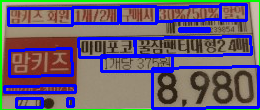

common-3.jpeg


In [ ]:
image = input_img
# OCR api
secret_key = "Y0l6ZHF1Um9CSWp3aHpJU3JDeFdpUGp1cG16T3hFQkg="
api_url = 'https://p0fsnflvaw.apigw.ntruss.com/custom/v1/27259/8a921c4c7d4e552c974b102e64c6227f3a2995ca938c066ddeb1442d6bf4b67c/general'

detections = []

# 단일 메세지 넣을 시
# if image:
for image in image_files: # 다량의 이미지 테스트 용
    original_img, cropped_img = predict2crop(model, folder_path = image_folder ,image_file = image)

    if cropped_img is None : continue

    # cropped_img = cv2.resize(cropped_img,(128,64)) # 필수

    response = CLOVA_api(secret_key ,api_url ,image = cropped_img)
    texts, img = imageOCR(response, img = cropped_img)
    detections.append(texts)


In [13]:
text = ''
for t in detections:
    if t == '': continue
    text += t
    text += '\n'
print(text)

고프로 HER010 Black할인30,000원2/0 0-649-000-619,000

샘표전품도2.5만원이상5천원상품권폰티나 스테이크소스265g에드와인) 상품권 100g당 1087원증정 2,88018.12.13-19.01

시베리아차가버섯800g 49 ,000

팩널티 블랜드 모카푸르 세트###2/3△ 216,000

4캔 9,400원10개 18,000원담을수록 덕덕구스_495ml캔이득 100ml당506원2,500

APPLE애플아이팟터치MP332GB/ BLACKAPPLE P00 TOUCH 32GB PLA 음악재생시최대38시간 이러프씨(58)이 동양성지동시최대6시간 DOCKMERE BUYE siruhannuhu SCREEN 계산후증점 1118 RT KY A MAIL 1100 443,900원

마르께스 테 리스?XR?레세르비2016HEALA 64,800R/ 0 100ml당 8640원 기타

신세계 ### 250531878 포인트 7,980

2만원 이상 구매시 3전원 상품권 증정(니베이/차구매기능) 11상품권 니네아 하이드레이션 케어 바디로션 1000ml1000ml당 9900원 증정20.11.05~20.11.189,900110/ 「 3

롯데ABC초콜릿10gC239R 2000 12/12~12/284 ,780###

진미미몬드180g 인절미아몬드180g4,880 4,88000g당 2711원 2711원산지 별도표기 원산지 별도표기

농심 사천백짬뽕 94g*12입 emartSICHIJAN WHITE CHAMPONG ###Tree UNION11,9402,500이마트 9,440 포인트카드적립 고객

(J)(B)무항생제신선초란(60)국내산100g당 489원 10배 포인트추가적립 12,90023-02-06~21-02-08 원 28/0/반/점/ 220408

스타벅스 미디엄 로스트 90입(기획)가격할인정상) 17,0001/0△ 0 22,000

아미고나쵸치즈콤보100g*6입emartAMIGO NACHO COMBO 1086 4010AIRANT 中 美 ANOWZAHL 9,980 

## Text preprocessing

In [ ]:
' '.join(texts)

'일반냉장고 R-B432GCWP.AKOR LG전자 나노참숯탈취 크기(WxHxD) 멀티냉각방식 755x1777x707 특급냉장 Bar 핸들타입'

In [ ]:
for d in detections:
    print(' '.join(d))

adidas SOLAR RIDE M CE449
주간추천상품 신라면멀티팩120g*5 2,490원
성동명 (원전시) 포장 년,월,일 두층 년,월,일 100g(원)중량(g) 100 10 가격(원) 1000 BARCORE DTHER
3238 553568 123 10 1/2 1285cvml ### 28S ### DEVALUAL 86585558 ### 400 Mid NO
삼성 갤럭시 ZFLIP SM-F700NZPAAKOO (0) 자급제폰 1,650,000 1,649,980 기준요금제: 자급제폰 24개월기준 출고가 통신사 지원금 아이마트 지원금 1,650,000 10 10 화면크기 용량 RAM 배터리 256GB (대각선) 12GB 3300mAh 170.2mm
LACARE 610 87 .........
쿠키 사이드 테이블 42 xH870 030 W1196 ₩49,900
푸르밀 비타요구르트 65ml*20입 806371 340163 판매가: 2,700원
빙그레요구르트 65ml+20의 07 672092 판매가: 3,000원
동원/요쿠르트 65ml*5*3 801155 403225 판매가: 3,000원
바이오플레-플레인 150ml*8입 판매가 : 3,400원
2014코카콜라브라질 250ml 1,250 8801094623203 /E 코카콜라음료
동서)맥심모카라이트 20T 801037 067651 판매가: 4,400원
맥심슈프림골드 20입 01037 00304 판매가: 4,900원
맥스웰커피믹스 240g 80103 7 035650 판매가: 2,500원
빙)요플레복숭아 100g*4개 01104 240390 판매가: 3,750원
0 빙그레 기획 닥터캡슐사과 520ml / 10ml당 86원 4,500원
₩ 19,000 SIZE EUR 20/21 자율안전확인신고필증번호 BO44R1466-1170 제조년월: 16.12 03179354904 061 6561/1 H&M KR/S11 0461949 001
켈로그콘푸로스트 600g 801083001425 판매가: 3,950원
유기농 유기농 인증 유기농원